# Import libraries

In [1]:
!pip install SimpleITK nibabel segmentation-models-3D tensorflow==2.15.0

INFO: pip is looking at multiple versions of segmentation-models-3d to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 4.7 MB/s eta 0:00:00


In [2]:
# general
import os
import random
from glob import glob

# data wrangling
import numpy as np
import matplotlib.pyplot as plt

# load .nii filesi
import nibabel as nib
import SimpleITK as sitk

# modelling
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Conv3D, BatchNormalization, MaxPooling3D, Concatenate, Conv3DTranspose, Input
from tensorflow.keras.models import Model

import segmentation_models_3D as sm

2024-02-06 12:09:26.017392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 12:09:26.017484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 12:09:26.139456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Segmentation Models: using `tf.keras` framework.


# Dataset Information

## Important definitions

**Lesion:** a region in an organ or tissue which has suffered damage through injury or disease, such as a wound, ulcer, abscess, or tumour.

## Types of Tumors:

**1. Necrotic and Non-Enhancing Tumor Core:** (Label=1)

- **Necrotic Core:** This refers to the dead or dying cells at the center of the tumor. The necrosis occurs due to the rapid growth of the tumor, which outstrips its blood supply, leading to a lack of oxygen and nutrients. On MRI, the necrotic core typically appears as a darker, non-enhancing area within the tumor on T1-weighted post-contrast images because it does not take up the contrast agent.

- **Non-Enhancing Tumor Core:** This includes the necrotic core and may also include other parts of the tumor that do not show an uptake of the contrast agent on T1-weighted post-contrast images. These non-enhancing regions can be made up of inactive or less active tumor cells, and they do not have the disrupted blood-brain barrier that is characteristic of more active tumor regions.

**2. Peritumoral Edema:** (Label=2)

- This refers to the swelling or accumulation of fluid around the tumor. Edema occurs as a result of the tumor's growth disrupting the normal functioning of the brain's blood vessels, leading to leakage of fluid into the surrounding brain tissue. On T2-weighted MRI scans, edema appears as a hyperintense (brighter) area surrounding the tumor. It's important to differentiate peritumoral edema from the tumor itself because it represents a reaction of the brain to the presence of the tumor rather than the tumor tissue.

**3. Enhancing Tumor:** (Label=4)

- This term describes the portion of the tumor that shows uptake of the contrast agent on T1-weighted post-contrast MRI scans. The enhancing tumor is typically considered to be the active, growing part of the tumor. The contrast agent (usually gadolinium-based) leaks through the disrupted blood-brain barrier in these areas, making them appear brighter on post-contrast images. The pattern and extent of enhancement can provide important diagnostic and prognostic information. In high-grade gliomas, such as glioblastoma, the enhancing portion often surrounds the necrotic core and is indicative of aggressive tumor behavior.

## About this Dataset

Each example contains 5 files. The first 4 files are variations of the MRI scan, providing varied information about the subject brain. The last file is the segmentation mask, which we are trying to predict.

1. `BraTS20_Training_***_flair.nii`: This is the FLAIR (Fluid Attenuated Inversion Recovery) MRI image. FLAIR is particularly good at highlighting lesions or abnormalities in the white matter of the brain.

2. `BraTS20_Training_***_t1.nii`: This is the T1-weighted MRI scan without contrast enhancement. T1 scans provide good anatomical detail and are particularly good at visualizing the gray matter of the brain.

3. `BraTS20_Training_***_t1ce.nii`: This is the T1-weighted MRI scan with contrast enhancement (CE), typically using a gadolinium-based contrast agent. The contrast enhancement helps to highlight regions of the brain where the blood-brain barrier is disrupted, which is common in active tumor areas.

4. `BraTS20_Training_***_t2.nii`: This is the T2-weighted MRI scan. T2 scans are good at visualizing fluid-filled spaces in the brain, and they provide complementary information to T1-weighted scans, especially for detecting edema and differentiating it from the tumor.

5. `BraTS20_Training_***_seg.nii`: This file contains the segmentation masks for the tumor regions. The segmentation contains pixel values in [0, 1, 2, 4], representing the 4 classes being segmented:
    - 0: Background
    - 1: Necrotic and Non-Enhancing Tumor Core
    - 2: Peritumoral Edema
    - 4: Enhancing Tumor

## Details about Scans

### FLAIR

In the dataset:
- `BraTS20_Training_***_flair.nii` - FLAIR MRI scan

FLAIR (Fluid Attenuated Inversion Recovery) is a special MRI imaging technique used to highlight the fluids in the brain and spinal cord. It is particularly useful for detecting lesions or areas of abnormality within the white matter.

### T1

In the dataset:
- `BraTS20_Training_***_t1.nii` - T1 MRI scan
- `BraTS20_Training_***_t1ce.nii` - T1 MRI scan with contrast enhancement

A T1-weighted MRI scan is a type of magnetic resonance imaging (MRI) that provides high-resolution images of the body's internal structures, with a particular emphasis on the contrast between different tissues based on their T1 relaxation times. In MRI, the term "T1" refers to the longitudinal relaxation time, which is the time it takes for protons in tissue to return to their equilibrium state after being excited by a radiofrequency pulse.

**Key Features of T1-Weighted Imaging:**
- **Tissue Contrast:** T1-weighted images are characterized by their ability to differentiate tissues based on their T1 relaxation properties. Fat appears bright (hyperintense), while fluids such as cerebrospinal fluid (CSF) appear dark (hypointense). This contrast is particularly useful for visualizing anatomical details and tissue boundaries.
- **Anatomical Detail:** These scans provide excellent anatomical detail, making them useful for assessing the brain's structure, including the gray and white matter, and for identifying abnormalities in soft tissues in other parts of the body.
- **Use of Contrast Agents:** T1-weighted imaging is often used in conjunction with gadolinium-based contrast agents, which shorten the T1 relaxation time of blood and enhance the contrast of blood vessels and areas of pathology, such as tumors or inflammation, making them appear brighter on the images.

### T2

In the dataset:
- `BraTS20_Training_***_t2.nii` - T2 MRI scan

A T2-weighted MRI scan is another fundamental type of magnetic resonance imaging (MRI) that provides images based on the T2 relaxation times of tissues. The T2 relaxation time, often referred to as the transverse or spin-spin relaxation time, is the time it takes for spinning protons in tissue to lose phase coherence among the planes perpendicular to the main magnetic field due to interactions among the protons themselves. This loss of coherence leads to a decrease in the MRI signal.

**Key Features of T2-Weighted Imaging:**
- **Tissue Contrast:** In T2-weighted images, tissues with longer T2 relaxation times appear brighter (hyperintense), while those with shorter T2 times appear darker (hypointense). Fluid-containing tissues, such as cerebrospinal fluid (CSF) in the brain or fluid in edematous tissues, typically have long T2 relaxation times and thus appear very bright. In contrast, fibrous tissue and bone have very short T2 relaxation times and appear very dark.
- **Fluid Sensitivity:** T2-weighted imaging is particularly sensitive to differences in the amount of water and fluid in tissues, making it excellent for visualizing edema, inflammation, and areas of fluid accumulation.
- **Pathology Detection:** The high contrast between fluid and other tissues makes T2-weighted MRI particularly useful for detecting pathological changes in the brain and body, such as tumors, infarctions (areas of dead tissue due to lack of blood flow), and demyelinating diseases like multiple sclerosis.

In [3]:
n_classes = 4

# Helpers

## Data Loading

In [4]:
def load_nii(path):
    file = sitk.ReadImage(path)
    array = sitk.GetArrayFromImage(file)
    return array

def load_example(root, example, files=["flair", "t1", "t1ce", "t2", "seg"]):
    example_path = os.path.join(root, example)

    images = []
    
    for file in files:
        image_path = os.path.join(example_path, f"{example}_{file}.nii")
        image = load_nii(image_path)
        images.append(image)
        
    return tuple(images)

## Visualization

In [5]:
def plot_scans(indices, flair=None, t1=None, t1ce=None, t2=None, seg=None):
    images = list(filter(lambda image: image is not None, [flair, t1, t1ce, t2, seg]))
    ncols = len(images)
    nrows = len(indices)
    plt.figure(figsize=(20, nrows*2))
    for i, index in enumerate(indices):
        print(f"Processing index {index}...")
        inc = 1
        if flair is not None:
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. Flair")
            plt.imshow(flair[index], cmap="gray")
            plt.axis("off")
            inc += 1
        if t1 is not None:
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. T1")
            plt.imshow(t1[index], cmap="gray")
            plt.axis("off")
            inc += 1
        if t1ce is not None:
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. T1 + CE")
            plt.imshow(t1ce[index], cmap="gray")
            plt.axis("off")
            inc += 1
        if t2 is not None:
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. T2")
            plt.imshow(t2[index], cmap="gray")
            plt.axis("off")
            inc += 1
        if seg is not None:
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. Segmentation")
            plt.imshow(seg[index], cmap="gray")
            plt.axis("off")
            inc += 1
    plt.tight_layout()
    plt.show()

In [6]:
def normalize_scan_slice(scan_slice, maximum=255):
    """normalize scan slice to [0, 255]"""
    if np.max(scan_slice) != 0:
        scan_slice = (scan_slice / np.max(scan_slice) * maximum).astype(np.int64)
    return scan_slice

def construct_overlay(scan_slice, seg_slice):
    height, width = scan_slice.shape
    # normalize scan to [0, 255]
    scan_slice = normalize_scan_slice(scan_slice)
    # construct overlay
    scan_slice_rgb = np.expand_dims(scan_slice, -1).repeat(3, -1) # copy scan_slice over 3 channels
    scan_slice_list = scan_slice_rgb.tolist()
    for i in range(height):
        for j in range(width):
            if seg_slice[i][j] == 1:
                scan_slice_list[i][j] = [255, 0, 0] # red: necrotic and non-enhancing tumor
            elif seg_slice[i][j] == 2:
                scan_slice_list[i][j] = [0, 255, 0] # green: peritumoral edema
            elif seg_slice[i][j] == 4:
                scan_slice_list[i][j] = [0, 0, 255] # blue: GD-enhancing tumor
    return np.array(scan_slice_list)

def plot_scans_with_seg_overlay(indices, flair=None, t1=None, t1ce=None, t2=None, seg=None, show_originals=True):
    if seg is None:
        raise Exception("Segmentation must be provided as parameter 'seg'")
    images = list(filter(lambda image: image is not None, [flair, t1, t1ce, t2]))
    ncols = len(images) if not show_originals else len(images) * 2
    nrows = len(indices)
    plt.figure(figsize=(20, nrows*2))
    for i, index in enumerate(indices):
        print(f"Processing index {index}...")
        seg_slice = seg[index] # (height, width)
        inc = 1
        if flair is not None:
            if show_originals:
                plt.subplot(nrows, ncols, i*ncols+inc)
                plt.title(f"{index}. Flair")
                plt.imshow(flair[index], cmap="gray")
                plt.axis("off")
                inc += 1
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. Flair + Seg")
            plt.imshow(construct_overlay(flair[index], seg_slice))
            plt.axis("off")
            inc += 1
        if t1 is not None:
            if show_originals:
                plt.subplot(nrows, ncols, i*ncols+inc)
                plt.title(f"{index}. T1")
                plt.imshow(t1[index], cmap="gray")
                plt.axis("off")
                inc += 1
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. T1 + Seg")
            plt.imshow(construct_overlay(t1[index], seg_slice))
            plt.axis("off")
            inc += 1
        if t1ce is not None:
            if show_originals:
                plt.subplot(nrows, ncols, i*ncols+inc)
                plt.title(f"{index}. T1 + CE")
                plt.imshow(t1ce[index], cmap="gray")
                plt.axis("off")
                inc += 1
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. (T1 + CE) + Seg")
            plt.imshow(construct_overlay(t1ce[index], seg_slice))
            plt.axis("off")
            inc += 1
        if t2 is not None:
            if show_originals:
                plt.subplot(nrows, ncols, i*ncols+inc)
                plt.title(f"{index}. T2")
                plt.imshow(t2[index], cmap="gray")
                plt.axis("off")
                inc += 1
            plt.subplot(nrows, ncols, i*ncols+inc)
            plt.title(f"{index}. T2 + Seg")
            plt.imshow(construct_overlay(t2[index], seg_slice))
            plt.axis("off")
            inc += 1
    
    plt.tight_layout()
    plt.show()

# Explore dataset

In [7]:
root = "/kaggle/input/MICCAI_BraTS2020_TrainingData/"

example = "BraTS20_Training_001" # another example is "BraTS20_Training_002"

flair, t1, t1ce, t2, seg = load_example(root, example)

print(flair.shape, t1.shape, t1ce.shape, t2.shape, seg.shape)

(155, 240, 240) (155, 240, 240) (155, 240, 240) (155, 240, 240) (155, 240, 240)


Processing index 70...
Processing index 71...
Processing index 72...
Processing index 73...
Processing index 74...
Processing index 75...
Processing index 76...
Processing index 77...
Processing index 78...
Processing index 79...


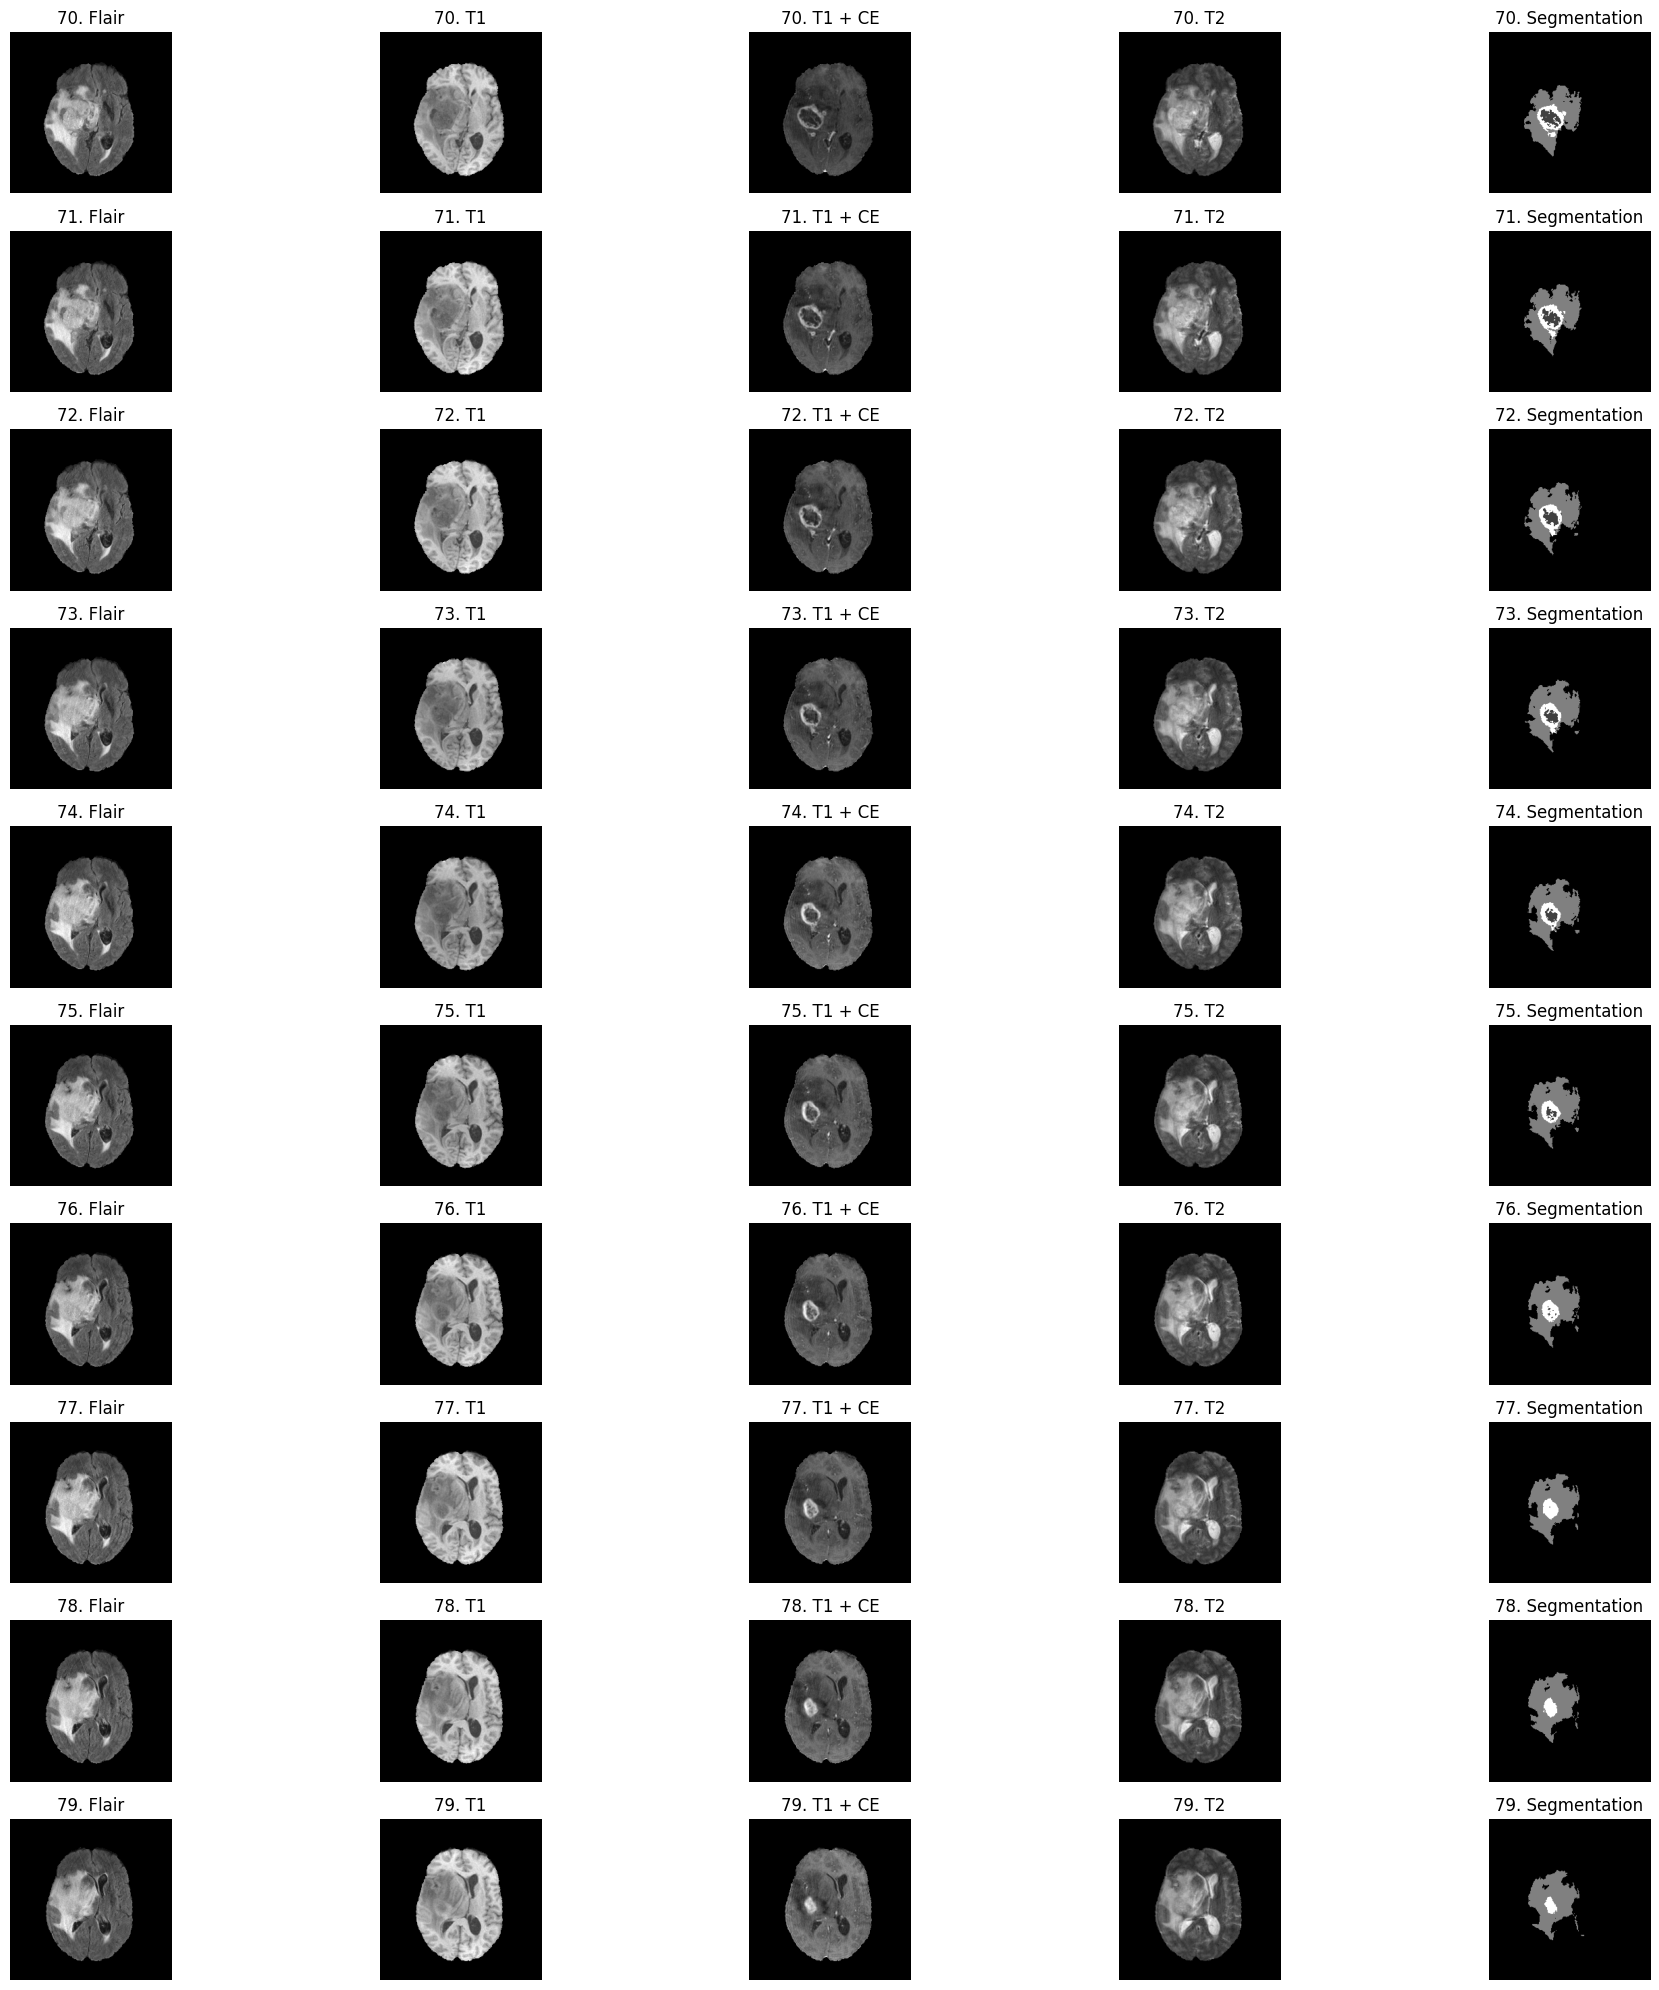

In [8]:
plot_scans(range(70, 80), flair=flair, t1=t1, t1ce=t1ce, t2=t2, seg=seg)

Processing index 70...
Processing index 71...
Processing index 72...
Processing index 73...
Processing index 74...
Processing index 75...
Processing index 76...
Processing index 77...
Processing index 78...
Processing index 79...


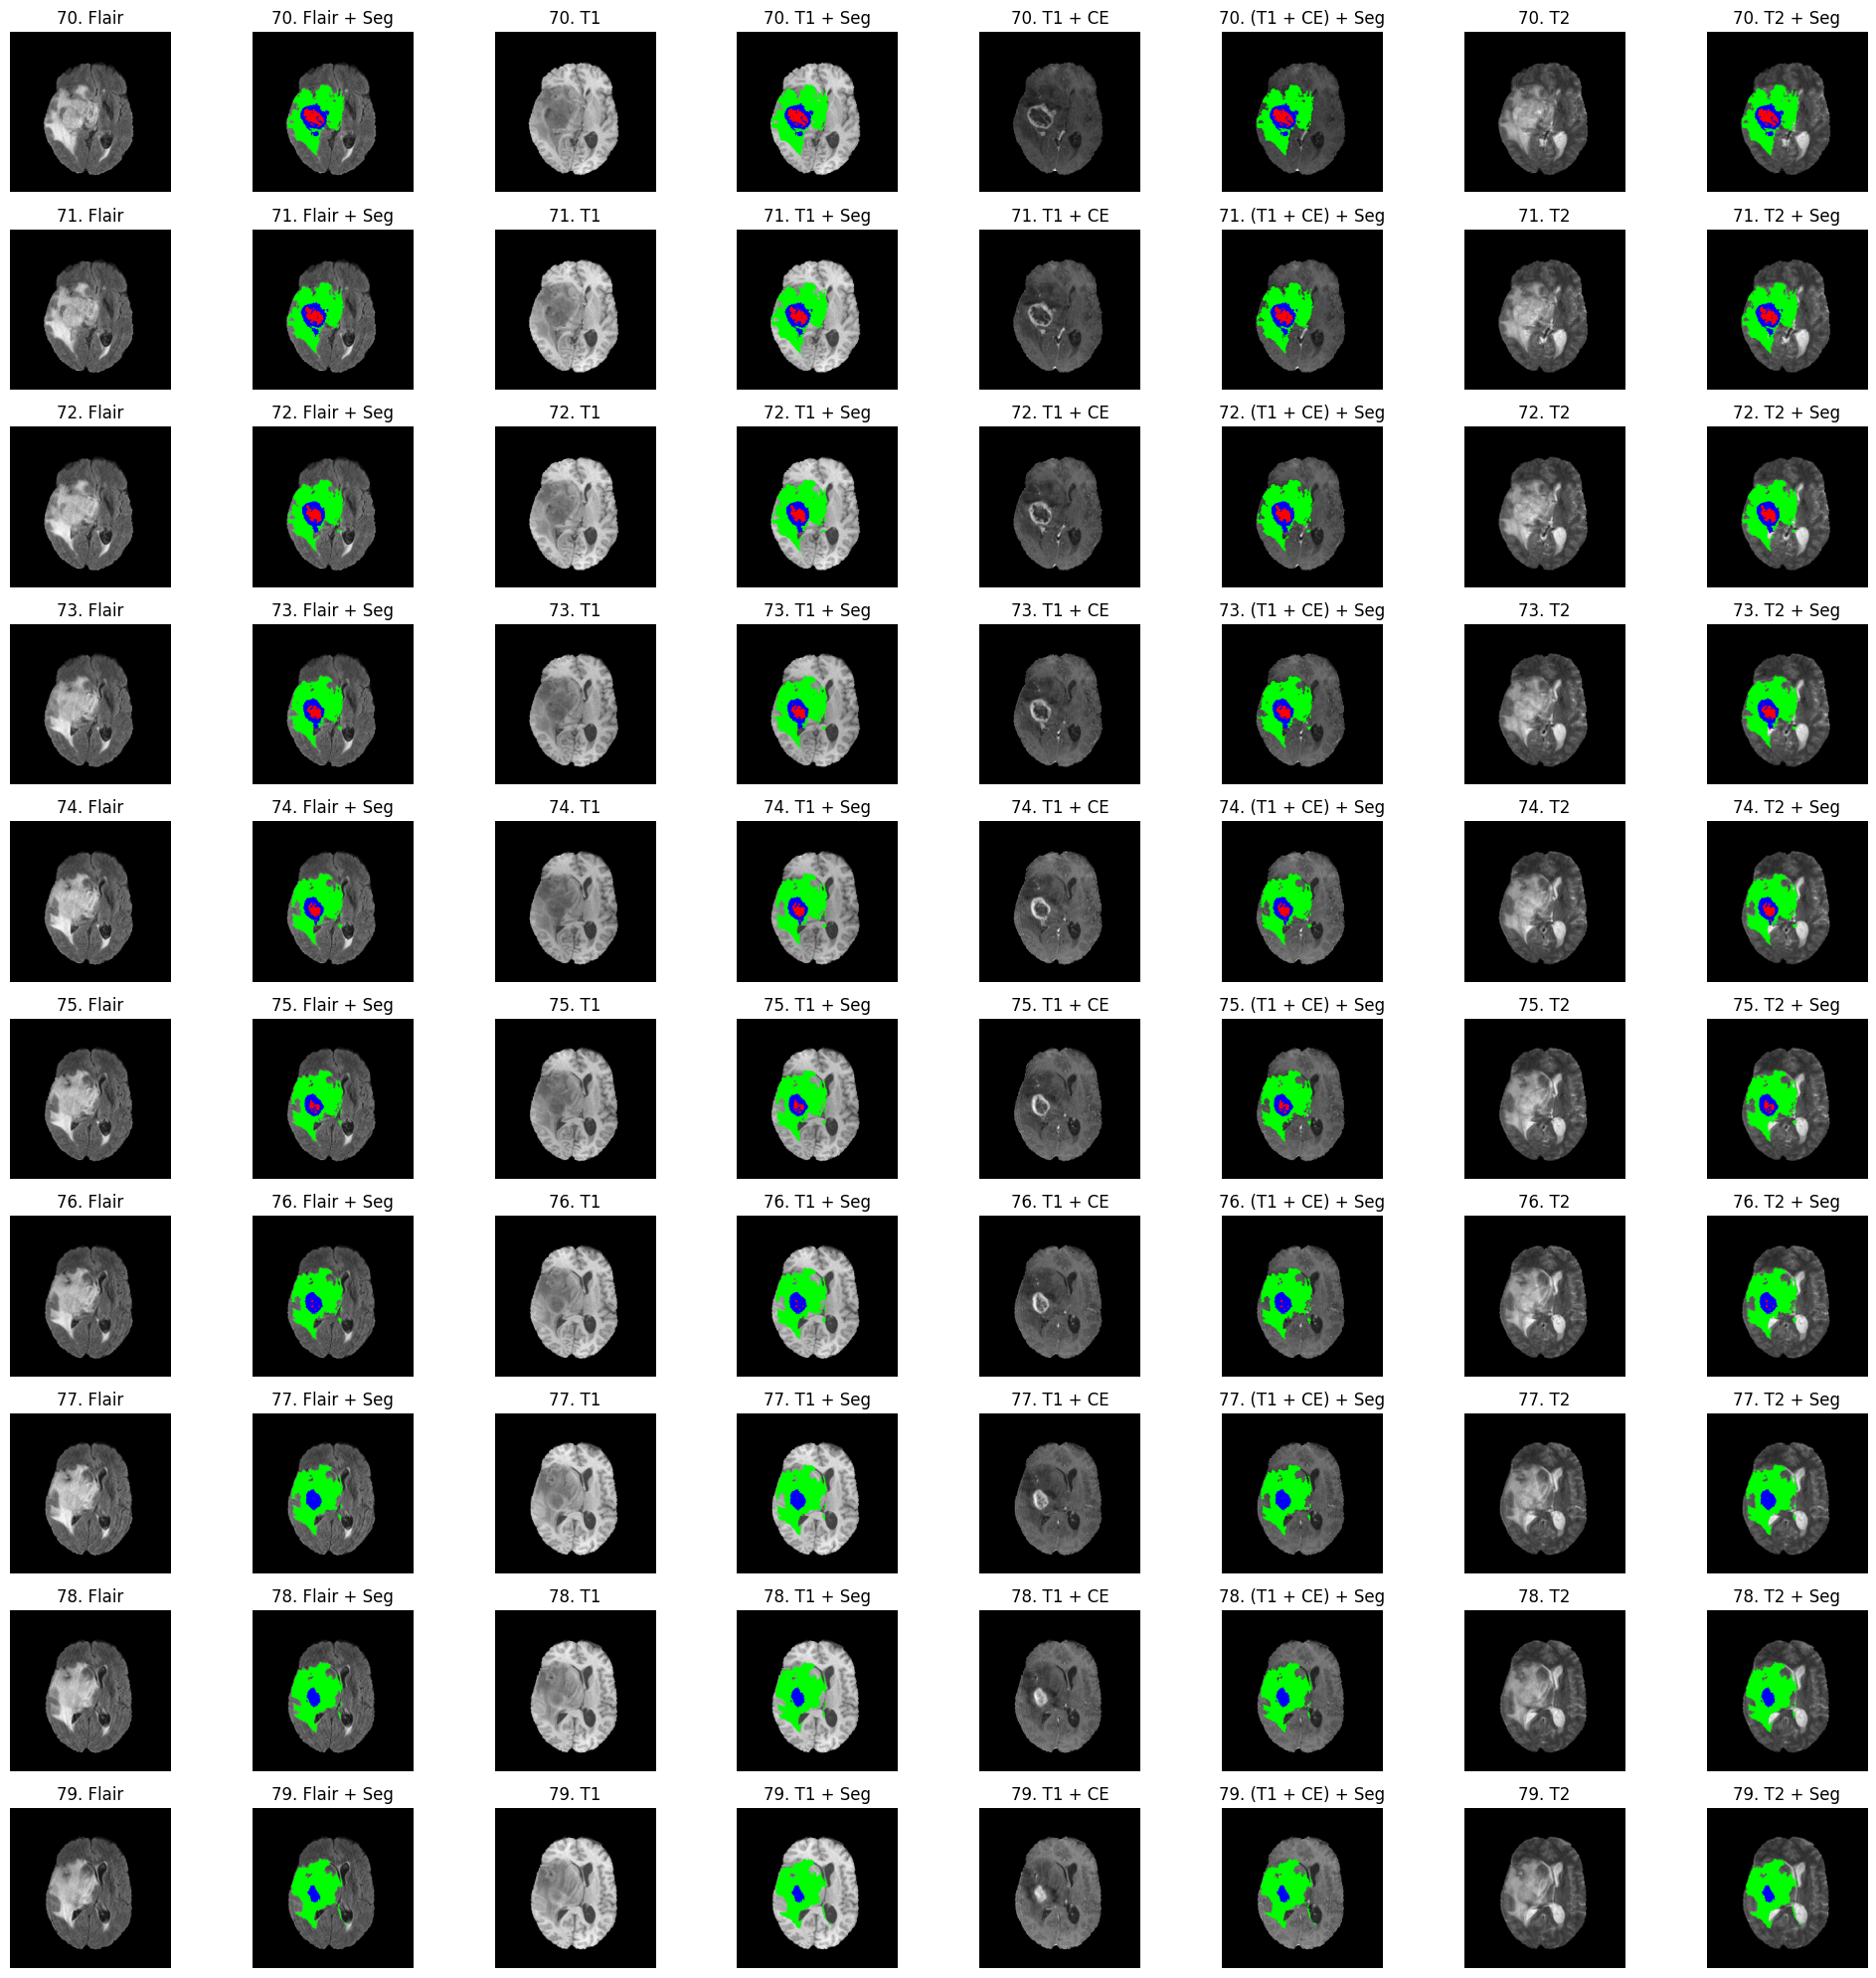

In [9]:
plot_scans_with_seg_overlay(range(70, 80), flair=flair, t1=t1, t1ce=t1ce, t2=t2, seg=seg)

# Baseline model with FLAIR scans

## Data Pipeline

In [10]:
val_pct = 0.2

In [11]:
def load_nii_file(file_path):
    """Load a NIfTI file and return the data as a NumPy array"""
    img = nib.load(file_path)
    return img.get_fdata()

def preprocess_data(nii_path, is_segmentation, label_mapping):
    """Load .nii image. If it is a segmentation image, one-hot encode and optionally relabel."""
    filler = np.zeros((240, 240, 5))
    if is_segmentation:        
        # preprocess segmentation
        seg_img = load_nii_file(nii_path) # load
        seg_img = np.concatenate((seg_img, filler), axis=-1) # convert shape from (240, 240, 155) to (240, 240, 160)
        for old_label, new_label in label_mapping.items(): # relabel segmentation
            seg_img[seg_img == old_label] = new_label
        seg_img = tf.one_hot(tf.cast(seg_img, tf.int32), depth=n_classes) # one-hot encode, adds channel dimension
        return seg_img
    else:
        # preprocess scan
        scan_img = load_nii_file(nii_path).astype(np.float32) # load
        if np.max(scan_img) != 0:
            scan_img = scan_img / np.max(scan_img) # normalize
        scan_img = np.concatenate((scan_img, filler), axis=-1) # convert shape from (240, 240, 155) to (240, 240, 160)
        scan_img = scan_img[..., np.newaxis] # batch channel dimension
        return scan_img


def data_generator(paths, is_segmentation, label_mapping={}):
    """Yield image"""
    for path in paths:
        yield preprocess_data(path, is_segmentation, label_mapping)
        

def create_single_modality_dataset(scan_paths, seg_paths):
    # relabel [0, 1, 2, 4] to [0, 1, 2, 3]
    label_mapping = {
        0: 0,
        1: 1,
        2: 2,
        4: 3
    }
    # scan dataset
    scan_ds = tf.data.Dataset.from_generator(
        lambda: data_generator(scan_paths, is_segmentation=False),
        output_types=tf.float32,
    )
    # segmentation dataset
    seg_ds = tf.data.Dataset.from_generator(
        lambda: data_generator(seg_paths, is_segmentation=True, label_mapping=label_mapping),
        output_types=tf.float32,
    )
    # zip datasets
    scan_seg_ds = tf.data.Dataset.zip((scan_ds, seg_ds))
    return scan_seg_ds

In [12]:
# get paths        
flair_paths = sorted(glob(os.path.join(root, "*/*flair.nii")))
seg_paths = sorted(glob(os.path.join(root, "*/*seg.nii")))

# abnormality in example 355: "W39_1998.09.19_Segm.nii" should be "BraTS20_Training_355_seg.nii"
seg_paths.insert(354, os.path.join(root, "BraTS20_Training_355", "W39_1998.09.19_Segm.nii"))

# split into train and test paths
train_flair_paths, val_flair_paths, train_seg_paths, val_seg_paths = train_test_split(
    flair_paths, seg_paths, test_size=val_pct
)

train_N = len(train_flair_paths)
val_N = len(val_flair_paths)
print(f"Number of training samples: {train_N}")
print(f"Number of validation samples: {val_N}")

Number of training samples: 295
Number of validation samples: 74


In [13]:
train_flair_seg_ds = create_single_modality_dataset(train_flair_paths, train_seg_paths)
val_flair_seg_ds = create_single_modality_dataset(val_flair_paths, val_seg_paths)

In [14]:
x, y = next(iter(train_flair_seg_ds))
x.shape, y.shape

(TensorShape([240, 240, 160, 1]), TensorShape([240, 240, 160, 4]))

### Batching

In [15]:
BATCH_SIZE = 1

In [16]:
train_flair_seg_ds = train_flair_seg_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_flair_seg_ds = val_flair_seg_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [17]:
xb, yb = next(iter(train_flair_seg_ds))
xb.shape, yb.shape

(TensorShape([1, 240, 240, 160, 1]), TensorShape([1, 240, 240, 160, 4]))

In [18]:
xb, yb = next(iter(val_flair_seg_ds))
xb.shape, yb.shape

(TensorShape([1, 240, 240, 160, 1]), TensorShape([1, 240, 240, 160, 4]))

## 3D U-Net

In [19]:
def conv_block(x, n_filters):
    """(conv -> relu -> bn) x 2"""
    x = Conv3D(n_filters, kernel_size=3, padding='same', use_bias=False, activation="relu")(x) 
    x = BatchNormalization()(x)
    x = Conv3D(n_filters, kernel_size=3, padding='same', use_bias=False, activation="relu")(x)
    x = BatchNormalization()(x)
    return x
    
def encoder_block(x, n_filters):
    """conv block and pooling"""
    x = conv_block(x, n_filters)
    p = MaxPooling3D((2, 2, 2))(x)
    return x, p

def decoder_block(x, p, n_filters):
    """upsample, skip connection, and conv block"""
    x = Conv3DTranspose(n_filters, (2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    x = Concatenate()([x, p])
    x = conv_block(x, n_filters)
    return x

def unet_model(n_classes, input_shape):
    inputs = Input(input_shape)
    
    # Contraction path, encoder
    c1, p1 = encoder_block(inputs, n_filters=8)
    c2, p2 = encoder_block(p1, n_filters=16)
    c3, p3 = encoder_block(p2, n_filters=32)
    c4, p4 = encoder_block(p3, n_filters=64)

    # Bottleneck
    bridge = conv_block(p4, n_filters=128)
    
#     Expansive path, decoder
    u4 = decoder_block(bridge, c4, n_filters=64)
    u3 = decoder_block(u4, c3, n_filters=32)
    u2 = decoder_block(u3, c2, n_filters=16)
    u1 = decoder_block(u2, c1, n_filters=8)

    outputs = Conv3D(n_classes, (1, 1, 1), activation='softmax')(u1)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [20]:
model = unet_model(n_classes=4, input_shape=(240, 240, 160, 1))

print(f"Input shape: {model.input_shape}")
print(f"Output shape: {model.output_shape}")
print(f"Trainable params: {np.sum([np.prod(v.get_shape()) for v in model.trainable_variables])}")

Input shape: (None, 240, 240, 160, 1)
Output shape: (None, 240, 240, 160, 4)
Trainable params: 1412532


In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 160, 1)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 240, 240, 160, 8)     216       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 240, 240, 160, 8)     32        ['conv3d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv3d_1 (Conv3D)           (None, 240, 240, 160, 8)     1728      ['batch_normalization[0][0

## Training

In [22]:
# loss function
class_weights = [0.25, 0.25, 0.25, 0.25]
dice_loss = sm.losses.DiceLoss(class_weights=class_weights)
focal_loss = sm.losses.CategoricalFocalLoss(alpha=class_weights, gamma=2)
total_loss = dice_loss + 1 * focal_loss

# optimizer
LR = 0.0001
opt = tf.keras.optimizers.Adam(LR)

# metrics
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile
model.compile(optimizer=opt, loss=total_loss, metrics=metrics)

In [23]:
# save checkpoints
checkpoint_path = "training_1/model.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_freq='epoch',
)]

In [24]:
EPOCHS = 50

model.fit(
    train_flair_seg_ds,
    validation_data=val_flair_seg_ds,
    epochs=EPOCHS,
    steps_per_epoch=train_N // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/50


I0000 00:00:1707221436.325762      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 [==============================] - 694s 2s/step - loss: 1.0209 - iou_score: 0.0697 - f1-score: 0.1054 - val_loss: 1.0214 - val_iou_score: 0.0071 - val_f1-score: 0.0098
Epoch 2/50
295/295 [==============================] - 62s 212ms/step - loss: 0.0000e+00 - iou_score: 0.0000e+00 - f1-score: 0.0000e+00 - val_loss: 1.0214 - val_iou_score: 0.0071 - val_f1-score: 0.0098
